In [24]:
import pandas as pd

df = pd.read_csv('Data/reviews.csv', encoding="ISO-8859-1")
df = df.sample(frac=1, random_state=0)
df.head()

,Text,Sentiment
11841,Al Pacino was once an actor capable of making ...,0
19602,After Chaplin made one of his best films: Doug...,0
45519,This movie is sort of a Carrie meets Heavy Met...,1
25747,I have fond memories of watching this visually...,1
42642,"In the '70s, Charlton Heston starred in sci-fi...",1


In [25]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  I am a fan of his ... This movie sucked really...   
1          24884  24884  An excellent example of what happens when one ...   

                
          freq  
Sentiment       
0            1  
1            1

In [26]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
x = df.apply(lambda row: remove_stop_words(row['Text']), axis=1)
y = df['Sentiment']

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding

model = Sequential() 
model.add(Embedding(max_words, 16, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 16)           160000    
                                                                 
 flatten_4 (Flatten)         (None, 8000)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1024128   
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,184,257
Trainable params: 1,184,257
Non-trainable params: 0
_________________________________________________________________


In [34]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=250)

Epoch 1/5
159/159 [==============================] - 2s 13ms/step - loss: 0.4884 - accuracy: 0.7514 - val_loss: 0.2699 - val_accuracy: 0.8890
Epoch 2/5
159/159 [==============================] - 2s 12ms/step - loss: 0.2191 - accuracy: 0.9140 - val_loss: 0.2579 - val_accuracy: 0.8917
Epoch 3/5
159/159 [==============================] - 2s 12ms/step - loss: 0.1397 - accuracy: 0.9504 - val_loss: 0.2904 - val_accuracy: 0.8872
Epoch 4/5
159/159 [==============================] - 2s 12ms/step - loss: 0.0631 - accuracy: 0.9826 - val_loss: 0.3680 - val_accuracy: 0.8771
Epoch 5/5
159/159 [==============================] - 2s 12ms/step - loss: 0.0192 - accuracy: 0.9965 - val_loss: 0.4530 - val_accuracy: 0.8740


[]

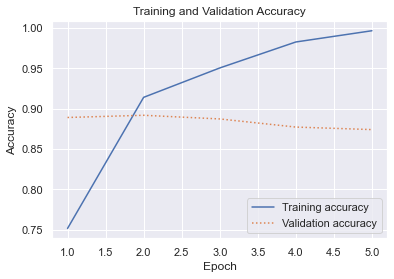

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [36]:
cleaned_text = remove_stop_words('Excellent food and fantastic service!')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.97209644

In [37]:
cleaned_text = remove_stop_words('The long lines and poor customer service really turned me off.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.030660957

## Conv1D

In [10]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
 
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

Model: "sequential_1"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 embedding_1 (Embedding)                     (None, 500, 32)                         320000         
                                                                                                    
 conv1d (Conv1D)                             (None, 494, 32)                         7200           
                                                                                                    
 max_pooling1d (MaxPooling1D)                (None, 98, 32)                          0              
                                                                                                    
 conv1d_1 (Conv1D)                           (None, 92, 32)                          7200           
                                                                     

In [11]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=250)

Epoch 1/5
159/159 [==============================] - 10s 60ms/step - loss: 0.4798 - accuracy: 0.7432 - val_loss: 0.2954 - val_accuracy: 0.8737
Epoch 2/5
159/159 [==============================] - 9s 59ms/step - loss: 0.2399 - accuracy: 0.9057 - val_loss: 0.2932 - val_accuracy: 0.8788
Epoch 3/5
159/159 [==============================] - 9s 60ms/step - loss: 0.1681 - accuracy: 0.9394 - val_loss: 0.3294 - val_accuracy: 0.8729
Epoch 4/5
159/159 [==============================] - 10s 60ms/step - loss: 0.0984 - accuracy: 0.9700 - val_loss: 0.3785 - val_accuracy: 0.8663
Epoch 5/5
159/159 [==============================] - 9s 58ms/step - loss: 0.0407 - accuracy: 0.9908 - val_loss: 0.5019 - val_accuracy: 0.8665


[]

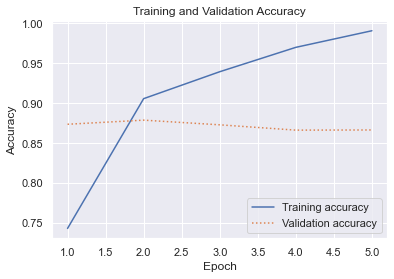

In [12]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [13]:
cleaned_text = remove_stop_words('Excellent food and fantastic service!')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.19359562

In [14]:
cleaned_text = remove_stop_words('The long lines and poor customer service really turned me off.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.2842962

## LSTM

In [15]:
from tensorflow.keras.layers import LSTM, Bidirectional
 
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))
#model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

Model: "sequential_2"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 embedding_2 (Embedding)                     (None, 500, 32)                         320000         
                                                                                                    
 bidirectional (Bidirectional)               (None, 500, 128)                        49664          
                                                                                                    
 bidirectional_1 (Bidirectional)             (None, 128)                             98816          
                                                                                                    
 dense_4 (Dense)                             (None, 1)                               129            
                                                                     

In [16]:
#hist = model.fit(x, y, validation_split=0.2, epochs=2, batch_size=250)

Epoch 1/2
159/159 [==============================] - 1543s 10s/step - loss: 0.4011 - accuracy: 0.8072 - val_loss: 0.2886 - val_accuracy: 0.8787
Epoch 2/2
159/159 [==============================] - 1609s 10s/step - loss: 0.2214 - accuracy: 0.9146 - val_loss: 0.2768 - val_accuracy: 0.8856


[]

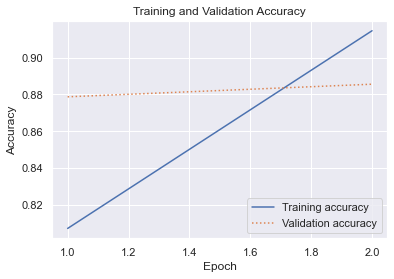

In [17]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [18]:
cleaned_text = remove_stop_words('Excellent food and fantastic service!')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.9655839

In [19]:
cleaned_text = remove_stop_words('The long lines and poor customer service really turned me off.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.31521955